# SET UP

In [ ]:
# ALL IMPORTS

import json
import os
from collections import defaultdict

from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms as transforms
import torch

import matplotlib.pyplot as plt
import numpy as np

import cv2
from torch.utils.data import DataLoader


In [ ]:
# mount our Google Drive

from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# unzip images in Google Drive

!unzip '/content/drive/MyDrive/Colab Notebooks/APS360/Project/chessred2k.zip' -d '/content/drive/MyDrive/Colab Notebooks/APS360/Project/ChessReD2K'

In [ ]:
# unzip images in Google Drive

!unzip '/content/drive/MyDrive/Colab Notebooks/APS360/Project/chessred.zip' -d '/content/drive/MyDrive/Colab Notebooks/APS360/Project/ChessReD'

In [ ]:
data_dir = '/content/drive/MyDrive/Colab Notebooks/APS360/Project/ChessReD'
annotation_dir = '/content/drive/MyDrive/Colab Notebooks/APS360/Project/annotations.json'

with open(annotation_dir, "r") as f:
            annotations = json.load(f)

# CONVERTING ANNOTATIONS TO FEN

In [ ]:
# IMPORTANT

image_id_to_path = {img['id']: os.path.join(data_dir, img['path']) for img in annotations['images']}
print(image_id_to_path)

image_to_pieces = defaultdict(list)
for ann in annotations['annotations']['pieces']:
    image_to_pieces[ann['image_id']].append(ann)
print(image_to_pieces[0])

print(image_id_to_path[103])

print(image_to_pieces[8000])

In [ ]:
# IMPORTANT
# uppercase is white, lowercase is black
id_to_piece = {
    0: 'P', 1: 'R', 2: 'N', 3: 'B', 4: 'Q', 5: 'K',
    6: 'p', 7: 'r', 8: 'n', 9: 'b', 10: 'q', 11: 'k',
    12: '1'  # empty
}

piece_to_label = {
    'P': 0, 'R': 1, 'N': 2, 'B': 3, 'Q': 4, 'K': 5,
    'p': 6, 'r': 7, 'n': 8, 'b': 9, 'q': 10, 'k': 11
}

def fen_to_label_vector(fen, empty_char='0'):
    squares = []
    for row in fen.split('/'):
        for ch in row:
            if ch == empty_char:
                squares.append(12)
            elif ch.isdigit():
                squares.extend([12] * int(ch))  # for compressed digits like 8
            else:
                squares.append(piece_to_label[ch])
    assert len(squares) == 64, f"Expected 64 squares but got {len(squares)} in FEN: {fen}"
    return torch.tensor(squares, dtype=torch.long)

# convert image piece list to FEN
def pieces_to_fen(piece_list):
    board = [['1'] * 8 for _ in range(8)]
    pos_to_index = lambda pos: (8 - int(pos[1]), ord(pos[0]) - ord('a'))

    for piece in piece_list:
        row, col = pos_to_index(piece['chessboard_position'])
        board[row][col] = id_to_piece[piece['category_id']]

    fen_rows = []
    for row in board:
        fen_row = ''
        count = 0
        for cell in row:
            if cell == '1':
                fen_row += '0'
            else:
                fen_row += cell
        fen_rows.append(fen_row)

    return '/'.join(fen_rows)
def label_vector_to_fen(label_vector):
    """
    Converts a length-64 label vector into a FEN string.
    Assumes label 12 is empty.
    """
    assert len(label_vector) == 64, f"Expected 64 squares, got {len(label_vector)}"

    fen_rows = []
    for i in range(0, 64, 8):
        row = label_vector[i:i+8]
        fen_row = ''
        empty_count = 0

        for val in row:
            if val == 12:  # empty square
                empty_count += 1
            else:
                if empty_count > 0:
                    fen_row += str(empty_count)
                    empty_count = 0
                fen_row += id_to_piece[int(val)]

        if empty_count > 0:
            fen_row += str(empty_count)

        fen_rows.append(fen_row)

    return '/'.join(fen_rows)

print(pieces_to_fen(image_to_pieces[2384]))
print(fen_to_label_vector(pieces_to_fen(image_to_pieces[10])))
print(fen_to_label_vector(pieces_to_fen(image_to_pieces[10])).shape)

# PREPROCESSING (HOUGH), SAVING TO DRIVE

In [ ]:
# VERY IMPORTANT, PREPROCESSING OF BOARD TO GET OVERHEAD IMG

import cv2
import numpy as np
import matplotlib.pyplot as plt

def detect_board_corners(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (5, 5), 0)
    edges = cv2.Canny(blur, 50, 150)

    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
    dilated = cv2.dilate(edges, kernel, iterations=2)

    contours, _ = cv2.findContours(dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)

    image_area = img.shape[0] * img.shape[1]

    for cnt in contours:
        epsilon = 0.02 * cv2.arcLength(cnt, True)
        approx = cv2.approxPolyDP(cnt, epsilon, True)

        if len(approx) == 4 and cv2.contourArea(approx) > 0.1 * image_area:
            corners = np.float32([pt[0] for pt in approx])
            ordered = order_points_robust(corners)
            return ordered, dilated

    return None, dilated


def order_points_robust(pts):
    # First, get bounding box
    x_sorted = pts[np.argsort(pts[:, 0]), :]
    left_most = x_sorted[:2, :]
    right_most = x_sorted[2:, :]

    # sort by y-coord
    tl, bl = left_most[np.argsort(left_most[:, 1]), :]
    tr, br = right_most[np.argsort(right_most[:, 1]), :]

    return np.array([tl, tr, br, bl], dtype="float32")  # Clockwise

def draw_corners(img, corners):
    img_copy = img.copy()
    labels = ["TL", "TR", "BR", "BL"]
    for i, pt in enumerate(corners):
        pt_int = tuple(np.int32(pt))
        cv2.circle(img_copy, pt_int, 14, (0, 0, 255), -1)
        cv2.putText(img_copy, labels[i], (pt_int[0] + 10, pt_int[1] - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 2.0, (255, 0, 0), 3)
    for i in range(4):
        pt1 = tuple(np.int32(corners[i]))
        pt2 = tuple(np.int32(corners[(i + 1) % 4]))
        cv2.line(img_copy, pt1, pt2, (0, 255, 0), 2)
    return img_copy


def warp_board(img, corners, output_size=400):
    src_pts = order_points_robust(corners)
    dst_pts = np.array([
        [0, 0],
        [output_size-1, 0],
        [output_size-1, output_size-1],
        [0, output_size-1]
    ], dtype="float32")

    M = cv2.getPerspectiveTransform(src_pts, dst_pts)
    warped = cv2.warpPerspective(img, M, (output_size, output_size))
    return warped

def slice_squares(warped, square_size=50):
    squares = []
    for row in range(8):
        for col in range(8):
            x1 = col * square_size
            y1 = row * square_size
            square = warped[y1:y1 + square_size, x1:x1 + square_size]
            squares.append(square)
    return squares

def preprocess_chessboard(image_path, output_size=400, display=True):
    img = cv2.imread(image_path)
    corners, debug_dilated = detect_board_corners(img)

    if corners is None:
        print("no corners")
        return
        raise ValueError("Board corners could not be detected.")

    corner_overlay = draw_corners(img, corners)
    warped = warp_board(img, corners, output_size)
    squares = slice_squares(warped, square_size=output_size // 8)

    if display:
        titles = ["Original", "Dilated Edges", "Corner Overlay", "Warped Top-Down"]
        images = [img, debug_dilated, corner_overlay, warped]

        plt.figure(figsize=(60, 20))
        for i in range(4):
            plt.subplot(1, 4, i + 1)
            img_disp = images[i]
            if len(img_disp.shape) == 2:
                plt.imshow(img_disp, cmap='gray')
            else:
                img_disp = cv2.cvtColor(img_disp, cv2.COLOR_BGR2RGB)
                plt.imshow(img_disp)
            plt.title(titles[i], fontsize=70)
            plt.axis('off')
        plt.tight_layout()
        plt.show()

    return warped, squares

test = preprocess_chessboard(image_id_to_path.get(annotations['splits']['chessred2k']['train']['image_ids'][10]))
print(pieces_to_fen(image_to_pieces[annotations['splits']['chessred2k']['train']['image_ids'][2]]))

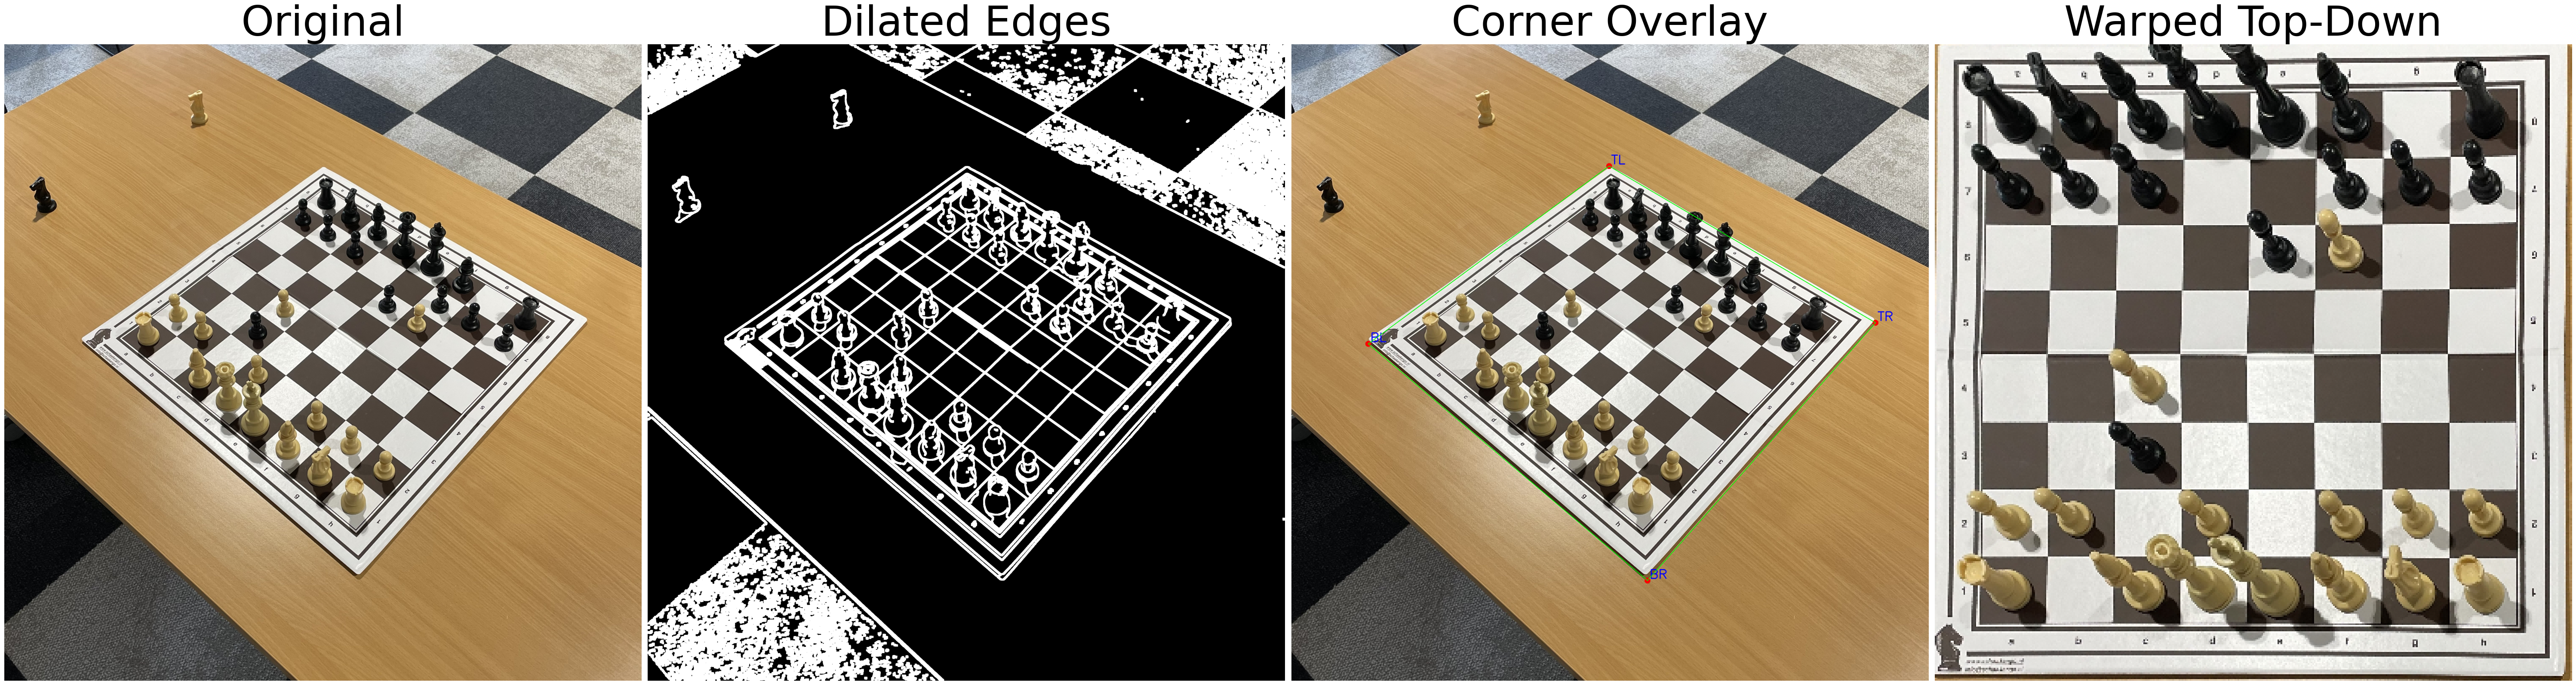

In [ ]:
def expand_fen(fen, empty_char='0'):
    board = []
    for row in fen.split('/'):
        expanded_row = []
        for ch in row:
            if ch.isdigit() and ch != empty_char:
                expanded_row.extend([empty_char] * int(ch))
            else:
                expanded_row.append(ch)
        board.append(expanded_row)
    return board

def compress_fen_row(row, empty_char='0'):
    compressed = ''
    count = 0
    for ch in row:
        if ch == empty_char:
            count += 1
        else:
            if count:
                compressed += str(count)
                count = 0
            compressed += ch
    if count:
        compressed += str(count)
    return compressed

def board_to_fen(board, empty_char='0'):
    return '/'.join([compress_fen_row(row, empty_char=empty_char) for row in board])
def rotate_fen_90(fen, empty_char='0'):
    board = expand_fen(fen, empty_char)
    rotated = list(zip(*board[::-1]))
    rotated = [list(row) for row in rotated]
    return board_to_fen(rotated, empty_char)

def rotate_fen_180(fen, empty_char='0'):
    board = expand_fen(fen, empty_char)
    rotated = [row[::-1] for row in board[::-1]]
    return board_to_fen(rotated, empty_char)

def rotate_fen_270(fen, empty_char='0'):
    board = expand_fen(fen, empty_char)
    rotated = list(zip(*board))[::-1]
    rotated = [list(row) for row in rotated]
    return board_to_fen(rotated, empty_char)
test_fen = "rnbqkbnr/pppppppp/00000000/00000000/00000000/00000000/PPPPPPPP/RNBQKBNR"

print("Original:     ", test_fen)
print("Rotated 90°:  ", rotate_fen_90(test_fen))
print("Rotated 180°: ", rotate_fen_180(test_fen))
print("Rotated 270°: ", rotate_fen_270(test_fen))


## PREPROCESS CHESSRED TRAIN

In [ ]:
# VERY IMPORTANT, SAVE WARPED CHESSRES2K IMAGES to DRIVE

import os
from google.colab import drive
from tqdm.notebook import tqdm


# Create save directory if it doesn't exist
save_dir = "/content/drive/MyDrive/Colab Notebooks/APS360/Project/ChessReD_Hough"
os.makedirs(save_dir, exist_ok=True)

X = []  # Paths to warped images
y = []  # Labels (4 FEN rotations each)

valid_ids = []
error_ids = []
invalid_warp_ids = []

# train_chessred2k_ids = annotations['splits']['chessred2k']['train']['image_ids']
chessred_ids = annotations['splits']['train']['image_ids']

for i in tqdm(chessred_ids, desc="Processing Images"):
    path = image_id_to_path.get(i)
    if path is None:
        error_ids.append(i)
        continue

    try:
        warped, _ = preprocess_chessboard(path, display=False)
        if warped is None or np.std(warped) < 50:
            invalid_warp_ids.append(i)
            continue

        # Save warped image
        img_save_path = os.path.join(save_dir, f"{i}.png")
        cv2.imwrite(img_save_path, warped)

        # Get FEN
        pieces = image_to_pieces[i]
        fen = pieces_to_fen(pieces)

        X.append(img_save_path)
        y.append(fen)
        valid_ids.append(i)

    except Exception as e:
        error_ids.append(i)


with open("/content/drive/MyDrive/Colab Notebooks/APS360/Project/chessred_hough.pkl", "wb") as f:
  pickle.dump((X, y), f)

print("✅ Total valid images:", len(valid_ids))
print("❌ Total errors:", len(error_ids))
print("⚠️ Total invalid warped:", len(invalid_warp_ids))


results:

Processing Images: 100%
 6479/6479 [35:45<00:00,  8.52it/s]
✅ Total valid images: 5325
❌ Total errors: 1151
⚠️ Total invalid warped: 3

## PREPROCESS CHESSRED VAL

In [ ]:
X = []  # Paths to warped images
y = []  # Labels (4 FEN rotations each)

valid_ids = []
error_ids = []
invalid_warp_ids = []

# train_chessred2k_ids = annotations['splits']['chessred2k']['train']['image_ids']
chessred_ids = annotations['splits']['val']['image_ids']

for i in tqdm(chessred_ids, desc="Processing Images"):
    path = image_id_to_path.get(i)
    if path is None:
        error_ids.append(i)
        continue

    try:
        warped, _ = preprocess_chessboard(path, display=False)
        if warped is None or np.std(warped) < 50:
            invalid_warp_ids.append(i)
            continue

        # Save warped image
        img_save_path = os.path.join(save_dir, f"{i}.png")
        cv2.imwrite(img_save_path, warped)

        # Get FEN
        pieces = image_to_pieces[i]
        fen = pieces_to_fen(pieces)

        X.append(img_save_path)
        y.append(fen)
        valid_ids.append(i)

    except Exception as e:
        error_ids.append(i)


with open("/content/drive/MyDrive/Colab Notebooks/APS360/Project/chessred_hough_val.pkl", "wb") as f:
  pickle.dump((X, y), f)

print("✅ Total valid images:", len(valid_ids))
print("❌ Total errors:", len(error_ids))
print("⚠️ Total invalid warped:", len(invalid_warp_ids))

results:

Processing Images: 100%
 2192/2192 [23:30<00:00,  7.89it/s]
✅ Total valid images: 1835
❌ Total errors: 357
⚠️ Total invalid warped: 0

## PREPROCESS CHESSRED TEST

In [ ]:
X = []  # Paths to warped images
y = []  # Labels (4 FEN rotations each)

valid_ids = []
error_ids = []
invalid_warp_ids = []

# train_chessred2k_ids = annotations['splits']['chessred2k']['train']['image_ids']
chessred_ids = annotations['splits']['test']['image_ids']

for i in tqdm(chessred_ids, desc="Processing Images"):
    path = image_id_to_path.get(i)
    if path is None:
        error_ids.append(i)
        continue

    try:
        warped, _ = preprocess_chessboard(path, display=False)
        if warped is None or np.std(warped) < 50:
            invalid_warp_ids.append(i)
            continue

        # Save warped image
        img_save_path = os.path.join(save_dir, f"{i}.png")
        cv2.imwrite(img_save_path, warped)

        # Get FEN
        pieces = image_to_pieces[i]
        fen = pieces_to_fen(pieces)

        X.append(img_save_path)
        y.append(fen)
        valid_ids.append(i)

    except Exception as e:
        error_ids.append(i)


with open("/content/drive/MyDrive/Colab Notebooks/APS360/Project/chessred_hough_test.pkl", "wb") as f:
  pickle.dump((X, y), f)

print("✅ Total valid images:", len(valid_ids))
print("❌ Total errors:", len(error_ids))
print("⚠️ Total invalid warped:", len(invalid_warp_ids))

results:

Processing Images: 100%
 2129/2129 [21:20<00:00,  9.61it/s]
✅ Total valid images: 1790
❌ Total errors: 336
⚠️ Total invalid warped: 3